Pipeline:

* delete trips with zero time trips
* delete trips with zero passenger count
* delete trips with zero distance
* delete trips started out of New York
* ----
* convert date to DateTime
* agregate data to new DF: hours/regions
* plot trip data in Empire State Building region
* count zero hour-region pairs



**Задание**

1. Загрузите данные за май 2016 года.

2. Проведите фильтрацию: удалите поездки с

    нулевой длительностью
    нулевым количеством пассажиров
    нулевым расстоянием поездки по счётчику
    координатами начала, не попадающими в прямоугольник Нью-Йорка 

3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.



In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
import calendar
import sys
from scipy.stats import binned_statistic_2d
from datetime import datetime, timedelta
from IPython.display import display
from ipywidgets import IntProgress

In [0]:
!wget "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv"
data_raw = pd.read_csv("./yellow_tripdata_2016-05.csv")
data_raw.head()

--2019-07-26 06:11:09--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.96.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.96.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1858526595 (1.7G) [application/octet-stream]
Saving to: ‘yellow_tripdata_2016-05.csv’

yellow_tripdata_201 100%[===================>]   1.73G  79.0MB/s    in 28s     

2019-07-26 06:11:42 (63.3 MB/s) - ‘yellow_tripdata_2016-05.csv’ saved [1858526595/1858526595]



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [0]:
!wget -O regions.csv -q "https://d3c33hcgiwev3.cloudfront.net/_5fd0fb3db5dfaaafa4d9fc4c00dd5ea8_regions.csv?Expires=1564185600&Signature=BH2bmc9vKp5F3zPtaDsM-xfcl9kY~VNuVUWzUnpIYgwx6vkm8ETj6kzwMPIb4rB9i6RfvdVsHS0aPGZsCZK6U-1IOWq~e9fiu4stR9H2rymxkRVCiA46Jq2DSX3vQvO~cvHoBsqGjwt0yKvqV2T4wIkTzOTobZefzu0W77l1uiQ_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"
regions = pd.read_csv("./regions.csv", ";")
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


**Data cleaning**

In [0]:
NY_long = [-74.25559, -73.70001]
NY_lat  = [40.49612, 40.91553]

zero_time_trips = data_raw.loc[data_raw.tpep_pickup_datetime == data_raw.tpep_dropoff_datetime].index
data = data_raw.drop(zero_time_trips)
print "{0} trips with zero time trips deleted".format(len(zero_time_trips))

zero_passenger_cnt = data.loc[data.passenger_count == 0].index
data = data.drop(zero_passenger_cnt)
print "{0} trips with zero passenger count deleted".format(len(zero_passenger_cnt))

zero_dist_trips = data.loc[data.trip_distance == 0].index
data = data.drop(zero_dist_trips)
print "{0} trips with zero distance deleted".format(len(zero_dist_trips))

out_NY_long_trips = data.loc[(data.pickup_longitude <= NY_long[0]) | (data.pickup_longitude >= NY_long[1])].index
data = data.drop(out_NY_long_trips)
out_NY_lat_trips  = data.loc[(data.pickup_latitude <= NY_lat[0]) | (data.pickup_latitude >= NY_lat[1])].index
data = data.drop(out_NY_lat_trips)
print "{0} trips, startes out of New York deleted".format(len(out_NY_long_trips) + len(out_NY_lat_trips))

print "Shape before cleaning: ", data_raw.shape
print "Shape after cleaning: ", data.shape

12268 trips with zero time trips deleted
522 trips with zero passenger count deleted
60641 trips with zero distance deleted
136901 trips, startes out of New York deleted
Shape before cleaning:  (11836853, 19)
Shape after cleaning:  (11626521, 19)


In [0]:
data.tpep_pickup_datetime  = data.tpep_pickup_datetime.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')) #convert time to DateTime type
data.tpep_dropoff_datetime = data.tpep_dropoff_datetime.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [0]:
def get_hours_cnt(date): #how many hours in month?
  return 24 * calendar.monthrange(date.year, date.month)[1]

**Agregating data**

In [0]:
start_date    = data.tpep_pickup_datetime[0]
may_hours_cnt = get_hours_cnt(data.tpep_pickup_datetime[0])

progress_bar = IntProgress(value=15, min=0, max=may_hours_cnt, \
                           description='Processing...', bar_style='success')
display(progress_bar)

xbins = np.append(regions.west.unique(), NY_long[1])
ybins = np.append(regions.south.unique(), NY_lat[1])

data_agregated = np.zeros([may_hours_cnt, 2500])

for hour in range(may_hours_cnt):
  time_interval = [start_date + timedelta(hours=hour), \
                   start_date + timedelta(hours=hour+1)]
  
  data_per_hour = data.loc[(data.tpep_pickup_datetime >= time_interval[0]) & \
                           (data.tpep_pickup_datetime <  time_interval[1])]  
  
  ret = binned_statistic_2d(data_per_hour.pickup_longitude, \
                            data_per_hour.pickup_latitude, \
                            None, 'count', bins=[xbins, ybins])
  
  for i in range(ret.statistic.shape[1]):
    data_agregated[hour, i*50:(i+1)*50] = ret.statistic[i, :]

  progress_bar.value += 1
  
indexes = [start_date + timedelta(hours=i) for i in range(may_hours_cnt)]
columns = ["Region_" + str(i) for i in range(1, 2501)]

data_agregated = pd.DataFrame(data_agregated, index=indexes, columns=columns, dtype='int64')
data_agregated.head()

IntProgress(value=15, bar_style=u'success', description=u'Processing...', max=744)

,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,Region_11,Region_12,Region_13,Region_14,Region_15,Region_16,Region_17,Region_18,Region_19,Region_20,Region_21,Region_22,Region_23,Region_24,Region_25,Region_26,Region_27,Region_28,Region_29,Region_30,Region_31,Region_32,Region_33,Region_34,Region_35,Region_36,Region_37,Region_38,Region_39,Region_40,...,Region_2461,Region_2462,Region_2463,Region_2464,Region_2465,Region_2466,Region_2467,Region_2468,Region_2469,Region_2470,Region_2471,Region_2472,Region_2473,Region_2474,Region_2475,Region_2476,Region_2477,Region_2478,Region_2479,Region_2480,Region_2481,Region_2482,Region_2483,Region_2484,Region_2485,Region_2486,Region_2487,Region_2488,Region_2489,Region_2490,Region_2491,Region_2492,Region_2493,Region_2494,Region_2495,Region_2496,Region_2497,Region_2498,Region_2499,Region_2500
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Let's plot scatter for one day**

In [0]:
def plot_scatter_with_grid(ax, ay, xbins, ybins):
  fig = plt.figure(figsize=(15, 13))
  plt.scatter(ax, ay, s = 0.5)
  
  for x_coord in xbins:
    plt.axvline(x=x_coord, alpha=0.3)

  for y_coord in ybins:
    plt.axhline(y=y_coord, alpha=0.3)

  plt.show()

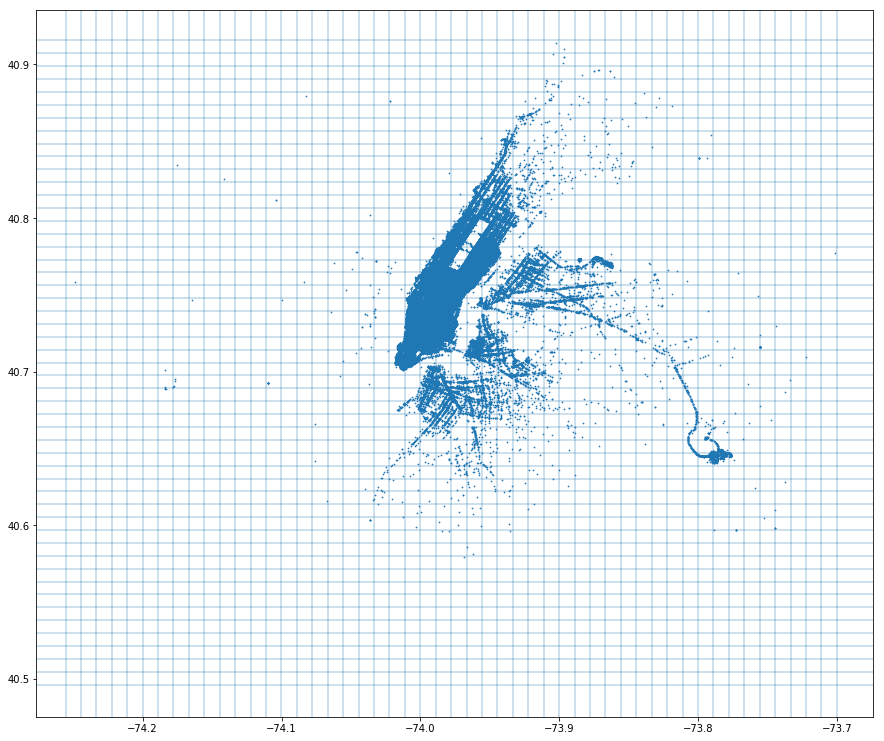

In [0]:
start_date = data.tpep_pickup_datetime[0]
time_interval = [start_date, start_date + timedelta(hours=24)]

data_per_day = data.loc[(data.tpep_pickup_datetime >= time_interval[0]) & \
                        (data.tpep_pickup_datetime <  time_interval[1])] 

plot_scatter_with_grid(data_per_day.pickup_longitude, data_per_day.pickup_latitude, xbins, ybins)

**Plotting trips amount near Empire State Building**

/usr/local/lib/python2.7/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


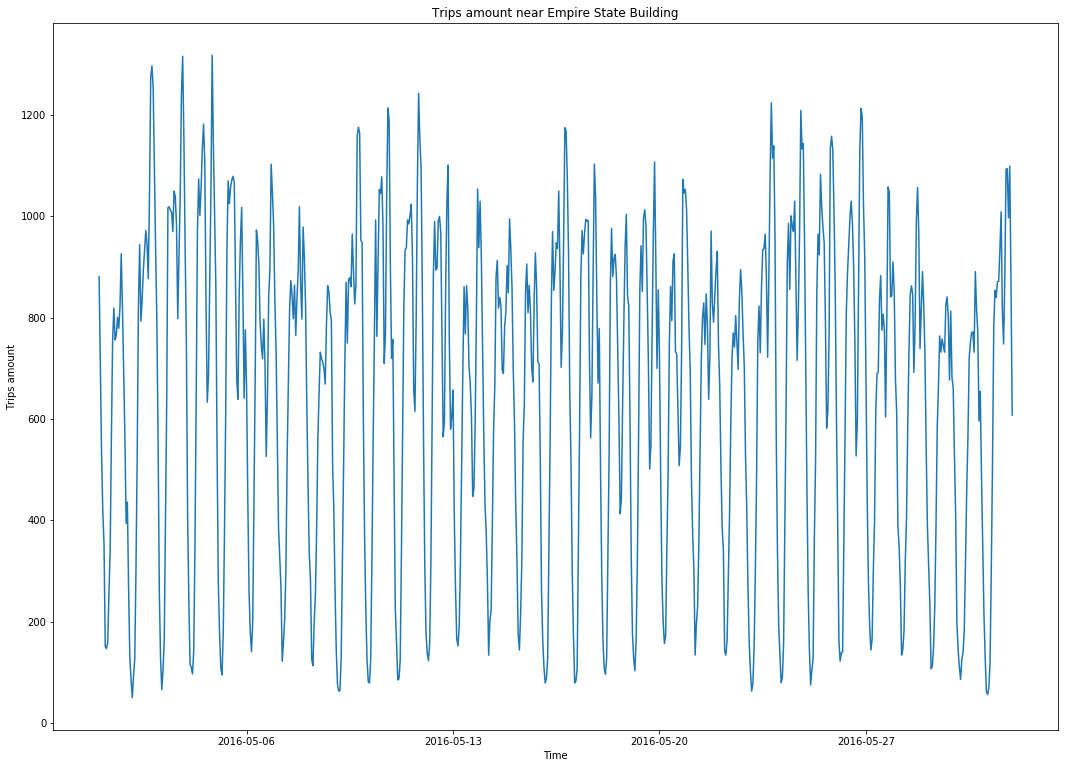

In [0]:
def get_region(coordinates): #get region number from coordinates
  return int(regions.loc[((coordinates[1] >= regions.west)  & \
                          (coordinates[1] < regions.east)   & \
                          (coordinates[0] >= regions.south) & \
                          (coordinates[0] < regions.north))].region)

empire_state_building = [40.748644, -73.985664]
empire_state_region   = "Region_" + str(get_region(empire_state_building))

fig = plt.figure(figsize=(18, 13))
plt.plot(data_agregated.index, data_agregated[empire_state_region])
plt.title("Trips amount near Empire State Building")
plt.xlabel('Time') 
plt.ylabel('Trips amount') 
plt.show()

**Counting zero hour-trips pairs**

In [0]:
zero_objects = len(data_agregated.values[data_agregated.values == 0])
print "Zero hour-trips pairs amount:", zero_objects

Zero hour-trips pairs amount: 1718238


In [0]:
data_agregated.to_csv("./data_agregated.csv", index=True)
data_test = pd.read_csv("./data_agregated.csv")
data_test.head()

,Unnamed: 0,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,Region_11,Region_12,Region_13,Region_14,Region_15,Region_16,Region_17,Region_18,Region_19,Region_20,Region_21,Region_22,Region_23,Region_24,Region_25,Region_26,Region_27,Region_28,Region_29,Region_30,Region_31,Region_32,Region_33,Region_34,Region_35,Region_36,Region_37,Region_38,Region_39,...,Region_2461,Region_2462,Region_2463,Region_2464,Region_2465,Region_2466,Region_2467,Region_2468,Region_2469,Region_2470,Region_2471,Region_2472,Region_2473,Region_2474,Region_2475,Region_2476,Region_2477,Region_2478,Region_2479,Region_2480,Region_2481,Region_2482,Region_2483,Region_2484,Region_2485,Region_2486,Region_2487,Region_2488,Region_2489,Region_2490,Region_2491,Region_2492,Region_2493,Region_2494,Region_2495,Region_2496,Region_2497,Region_2498,Region_2499,Region_2500
0,2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
